<a href="https://colab.research.google.com/github/DhrubaAdhikary/eagleview/blob/main/Eagleview_Inference_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 8412, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 8412 (delta 64), reused 80 (delta 39), pack-reused 8286
Receiving objects: 100% (8412/8412), 9.53 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (5806/5806), done.


In [2]:
!pip install -r yolov5/requirements.txt

     |████████████████████████████████| 636 kB 15.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pycocotools
from pycocotools.coco import COCO 
import sys
import json
import cv2
import random
random.seed(108)

In [4]:
!mkdir overlays
!mkdir yolo_annots


In [5]:
!wget  https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz

--2021-07-26 04:02:23--  https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz
Resolving evp-ml-data.s3.us-east-2.amazonaws.com (evp-ml-data.s3.us-east-2.amazonaws.com)... 52.219.80.32
Connecting to evp-ml-data.s3.us-east-2.amazonaws.com (evp-ml-data.s3.us-east-2.amazonaws.com)|52.219.80.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 734266940 (700M) [application/x-gzip]
Saving to: ‘trainval.tar.gz’

trainval.tar.gz     100%[===================>] 700.25M  30.3MB/s    in 25s     

2021-07-26 04:02:49 (27.7 MB/s) - ‘trainval.tar.gz’ saved [734266940/734266940]



In [6]:
!tar -xvf /content/trainval.tar.gz

trainval/
trainval/images/
trainval/annotations/
trainval/annotations/bbox-annotations.json
trainval/images/image_000001631.jpg
trainval/images/image_000000249.jpg
trainval/images/image_000001157.jpg
trainval/images/image_000001143.jpg
trainval/images/image_000001625.jpg
trainval/images/image_000000513.jpg
trainval/images/image_000000275.jpg
trainval/images/image_000000261.jpg
trainval/images/image_000001619.jpg
trainval/images/image_000000507.jpg
trainval/images/image_000001194.jpg
trainval/images/image_000001180.jpg
trainval/images/image_000001816.jpg
trainval/images/image_000001802.jpg
trainval/images/image_000001355.jpg
trainval/images/image_000001433.jpg
trainval/images/image_000000739.jpg
trainval/images/image_000001427.jpg
trainval/images/image_000001341.jpg
trainval/images/image_000001369.jpg
trainval/images/image_000000077.jpg
trainval/images/image_000000711.jpg
trainval/images/image_000002106.jpg
trainval/images/image_000002112.jpg
trainval/images/image_000000705.jpg
trainval

In [7]:
COCO_ANNO_PATH = '/content/trainval/annotations/bbox-annotations.json'
COCO_IMG_PATH  = '/content/trainval/images'

coco = COCO(COCO_ANNO_PATH)

color_map = {
    'people':   'red',
    'car':  'blue'
}

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [8]:
def viz_fn(image,annotations,idx=0):

    for elem in annotations:
        holder_dict={}
        holder_dict=elem
        category=holder_dict['category_id']
        x,y,w,h=holder_dict['bbox'][0],holder_dict['bbox'][1],holder_dict['bbox'][2],holder_dict['bbox'][3]
        
        if(category==1):
            img=cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
        else:
            img=cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    cv2.imwrite('/content/overlays/'+str(idx)+'.png',img)
    return

In [9]:
def extract_info_from_json(image_info,annotations):
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in annotations:
        # Get the file name 
        info_dict['filename'] = image_info['file_name']
            
        # Get the image size
        image_size=[image_info['width'],image_info['height'],3]
        info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        #impute class as 0 and 1 instead of 1 and 2 as provided in category_id as YOLO classes start from 0.
        bbox = {} 
        if(elem['category_id']==1):
          bbox['class']=0
        elif(elem['category_id']==2):
          bbox['class']=1
        bbox['xmin']=elem['bbox'][0]
        bbox['ymin']=elem['bbox'][1]
        bbox['xmax']=elem['bbox'][2]+elem['bbox'][0]
        bbox['ymax']=elem['bbox'][3]+elem['bbox'][1]      
        info_dict['bboxes'].append(bbox)
    
    return info_dict

In [10]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"person": 0,
                           "car": 1}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = b['class']#class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("yolo_annots",info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [11]:
for image_id in coco.imgs.keys():
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))
    
    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    viz_fn(image,annotations,image_id)
    info_dict=extract_info_from_json(image_info,annotations)
    convert_to_yolov5(info_dict)

In [12]:
annotations = [os.path.join('yolo_annots', x) for x in os.listdir('yolo_annots') if x[-3:] == "txt"]

In [13]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    


    image.resize((1024,1024))
    plt.imshow(np.array(image))
    plt.savefig('dummy.png')
    plt.show()




yolo_annots/image_000002055.txt
/content/trainval/images//image_000002055.jpg


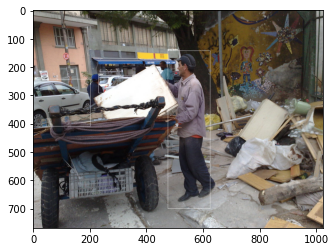

In [14]:
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
print(annotation_file)
image_file = annotation_file.replace("yolo_annots","/content/trainval/images/").replace("annotations", "images").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [15]:
# Read images and annotations
images = [os.path.join('/content/trainval/images/', x) for x in os.listdir('/content/trainval/images/')]
annotations = [os.path.join('yolo_annots', x) for x in os.listdir('yolo_annots') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [16]:
if not os.path.exists('images/train'):
  os.makedirs("images/train")
if not os.path.exists('images/test'):
  os.makedirs("images/test")
if not os.path.exists('images/val'):
  os.makedirs("images/val")
if not os.path.exists('annotations/train'):
  os.makedirs("annotations/train")
if not os.path.exists('annotations/test'):
  os.makedirs("annotations/test")
if not os.path.exists('annotations/val'):
  os.makedirs("annotations/val")


In [17]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [18]:
#Rename the annotations folder to labels, as this is where YOLO v5 expects the annotations to be located in.
!mv annotations labels


In [40]:
#check data/hyps/hyp.scratch.yaml
#create eagleview.yaml inside yolov5/data folder 
# train: /content/images/train/
# val:  /content/images/val/
# test: /content/images/test/

# # number of classes
# nc: 2

# # class names
# names: ["person","car"]


file1 = open('/content/yolov5/data/eagleview.yaml', 'w')
file1.writelines("train: /content/images/train/\n")
file1.writelines("val:  /content/images/val/\n")
file1.writelines("test:  /content/images/test/\n")
file1.writelines("nc: 2  \n")
file1.writelines('names: ["person","car"]\n')
file1.close()


In [41]:
#!python /content/yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 50 --data eagleview.yaml --weights yolov5s.pt --workers 24 --name yolo_eagle_det

In [42]:
# detections_dir = "runs/detect/yolo_eagle_det/"
# detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

# random_detection_image = Image.open(random.choice(detection_images))
# plt.imshow(np.array(random_detection_image))

In [43]:
!python /content/yolov5/val.py --weights /content/best.pt --data eagleview.yaml --task test --name yolo_det

val: data=./yolov5/data/eagleview.yaml, weights=['/content/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det, exist_ok=False, half=False
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v5.0-316-g8acb573 torch 1.9.0+cu102 CPU

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPs
test: Scanning '/content/labels/test.cache' images and labels... 

In [48]:

shutil.rmtree("/content/runs/val/yolo_det6")

In [49]:
!zip -r /content/file.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/val/ (stored 0%)
  adding: content/runs/val/.ipynb_checkpoints/ (stored 0%)
  adding: content/runs/val/yolo_det7/ (stored 0%)
  adding: content/runs/val/yolo_det7/F1_curve.png (deflated 12%)
  adding: content/runs/val/yolo_det7/val_batch2_pred.jpg (deflated 2%)
  adding: content/runs/val/yolo_det7/val_batch1_labels.jpg (deflated 3%)
  adding: content/runs/val/yolo_det7/confusion_matrix.png (deflated 35%)
  adding: content/runs/val/yolo_det7/R_curve.png (deflated 13%)
  adding: content/runs/val/yolo_det7/PR_curve.png (deflated 12%)
  adding: content/runs/val/yolo_det7/val_batch2_labels.jpg (deflated 2%)
  adding: content/runs/val/yolo_det7/val_batch1_pred.jpg (deflated 2%)
  adding: content/runs/val/yolo_det7/P_curve.png (deflated 11%)
  adding: content/runs/val/yolo_det7/val_batch0_pred.jpg (deflated 6%)
  adding: content/runs/val/yolo_det7/val_batch0_labels.jpg (deflated 6%)


In [50]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>